# MODELOS DE REDES PARA DENGUE BARRANCABERMEJA

### Cargue de librerias requeridas

In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
from pandas import concat
from pandas import read_csv
from pandas import DataFrame
import tensorflow as tf
from tensorflow import keras
import os
import datetime
import IPython
import IPython.display
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Flatten, LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Input, Reshape, RepeatVector, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
%matplotlib inline
from scipy.stats import randint as sp_randint
np.random.seed(123) # for reproducibility
import warnings
warnings.filterwarnings('ignore')

### Cargar la base de datos

In [2]:
datos = read_csv('Barranca_Zika_Lags.csv', encoding='latin-1', sep=";")

# Se eliminan las columnas de las variables que No se van a utilizar
datos = datos.drop(['Municipio', 'Año', 'Semana_Epi',
       'Temp_Seca_Max_Dia_Prom', 'Temp_Seca_Max_Dia_Prom_1',
       'Temp_Seca_Max_Dia_Prom_2', 'Temp_Seca_Max_Dia_Prom_3',
       'Temp_Seca_Max_Dia_Prom_4', 'Temp_Seca_Max_Dia_Prom_5',
       'Temp_Seca_Max_Dia_Prom_6', 'Temp_Seca_Max_Sem', 'Temp_Seca_Max_Sem_1',
       'Temp_Seca_Max_Sem_2', 'Temp_Seca_Max_Sem_3', 'Temp_Seca_Max_Sem_4',
       'Temp_Seca_Max_Sem_5', 'Temp_Seca_Max_Sem_6', 'Temp_Seca_Min_Dia_Prom',
       'Temp_Seca_Min_Dia_Prom_1', 'Temp_Seca_Min_Dia_Prom_2', 'Temp_Seca_Min_Dia_Prom_4',
       'Temp_Seca_Min_Dia_Prom_5', 'Temp_Seca_Min_Sem', 'Temp_Seca_Min_Sem_1', 'Temp_Seca_Min_Sem_2',
       'Temp_Seca_Min_Sem_3', 'Temp_Seca_Min_Sem_4', 'Temp_Seca_Min_Sem_5',
       'Temp_Seca_Min_Sem_6', 'Prom_Dia_Preci', 'Prom_Dia_Preci_1',
       'Prom_Dia_Preci_2', 'Prom_Dia_Preci_3', 'Prom_Dia_Preci_4',
       'Prom_Dia_Preci_5', 'Prom_Dia_Preci_6', 'Total_Preci_Sem',
       'Total_Preci_Sem_1', 'Total_Preci_Sem_2', 'Total_Preci_Sem_3',
       'Total_Preci_Sem_4', 'Total_Preci_Sem_5', 'Total_Preci_Sem_6',
       'Temp_Max_Dia_Prom', 'Temp_Max_Dia_Prom_1', 'Temp_Max_Dia_Prom_2',
       'Temp_Max_Dia_Prom_3', 'Temp_Max_Dia_Prom_4', 'Temp_Max_Dia_Prom_5',
       'Temp_Max_Dia_Prom_6', 'Temp_Max_Sem', 'Temp_Max_Sem_1',
       'Temp_Max_Sem_2', 'Temp_Max_Sem_3', 'Temp_Max_Sem_4', 'Temp_Max_Sem_5',
       'Temp_Max_Sem_6', 'Temp_Min_Dia_Prom', 'Temp_Min_Dia_Prom_1',
       'Temp_Min_Dia_Prom_2', 'Temp_Min_Dia_Prom_3', 'Temp_Min_Dia_Prom_4',
       'Temp_Min_Dia_Prom_5', 'Temp_Min_Dia_Prom_6', 'Temp_Min_Sem',
       'Temp_Min_Sem_1', 'Temp_Min_Sem_2', 'Temp_Min_Sem_3', 'Temp_Min_Sem_4',
       'Temp_Min_Sem_5', 'Temp_Min_Sem_6', 'Hum_Rel_Max', 'Hum_Rel_Max_1',
       'Hum_Rel_Max_2', 'Hum_Rel_Max_3', 'Hum_Rel_Max_4', 'Hum_Rel_Max_5',
       'Hum_Rel_Max_6', 'Hum_Rel_Min', 'Hum_Rel_Min_1', 'Hum_Rel_Min_2',
       'Hum_Rel_Min_3', 'Hum_Rel_Min_4', 'Hum_Rel_Min_5'],axis=1)
datos.columns

Index(['Casos_Zika', 'Temp_Seca_Min_Dia_Prom_3', 'Temp_Seca_Min_Dia_Prom_6',
       'Hum_Rel_Min_6'],
      dtype='object')

In [3]:
#Se verifican datos nulos o faltantes
datos.isnull().sum()

Casos_Zika                  0
Temp_Seca_Min_Dia_Prom_3    0
Temp_Seca_Min_Dia_Prom_6    0
Hum_Rel_Min_6               6
dtype: int64

In [4]:
#Se realiza la imputación de los datos
knnImputer = KNNImputer (missing_values=np.nan, n_neighbors=2, 
                         weights="uniform", metric="nan_euclidean")
# Ajustamos el modelo e imputamos los missing values
knnImputer.fit(datos[['Hum_Rel_Min_6']])
datos['Hum_Rel_Min_6'] = knnImputer.transform(datos[['Hum_Rel_Min_6']]).ravel()

datos.shape

(104, 4)

### División de los datos en set de entrenamiento y prueba

In [5]:
train_size = int(len(datos) * 0.7)
test_size = len(datos) - train_size
train, test = datos.iloc[0:train_size], datos.iloc[train_size:len(datos)]
print(len(train), len(test))

72 32


In [6]:
f_columns = ['Temp_Seca_Min_Dia_Prom_3', 'Temp_Seca_Min_Dia_Prom_6', 'Hum_Rel_Min_6']
f_transformer = MinMaxScaler(feature_range=(0, 1))
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())

In [7]:
dengue_transformer = MinMaxScaler(feature_range=(0, 1))
dengue_transformer = dengue_transformer.fit(train[['Casos_Zika']])
train['Casos_Zika'] = dengue_transformer.transform(train[['Casos_Zika']])
test['Casos_Zika'] = dengue_transformer.transform(test[['Casos_Zika']])

In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# MODELO LSTM

In [11]:
# Creación de X_train, y_train, X_test y y_test Para el modelo LSTM

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_LSTM, y_train_LSTM = create_dataset(train, train.Casos_Zika, time_steps)
X_test_LSTM, y_test_LSTM = create_dataset(test, test.Casos_Zika, time_steps)
print(X_train_LSTM.shape, y_train_LSTM.shape, X_test_LSTM.shape, y_test_LSTM.shape )

(65, 7, 4) (65,) (25, 7, 4) (25,)


### Construcción, Compilación y entrenamiento del modelo LSTM

In [12]:
Barr_LSTM_model_11 = keras.Sequential()
    
# CAPA DE ENTRADA
Barr_LSTM_model_11.add(keras.layers.InputLayer(input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    
    
#CAPAS INTERMEDIAS

Barr_LSTM_model_11.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Barr_LSTM_model_11.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Barr_LSTM_model_11.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Barr_LSTM_model_11.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Barr_LSTM_model_11.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Barr_LSTM_model_11.h5'
checkpoint_LSTM = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_LSTM = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_LSTM = Barr_LSTM_model_11.fit(X_train_LSTM,y_train_LSTM, validation_data=(X_test_LSTM,y_test_LSTM), 
                                     verbose=2, epochs=100, callbacks=[monitor_LSTM, checkpoint_LSTM])
Barr_LSTM_model_11.load_weights(model_filepath)

Epoch 1/100
3/3 - 9s - loss: 0.0335 - mse: 0.0335 - val_loss: 0.0019 - val_mse: 0.0019 - 9s/epoch - 3s/step
Epoch 2/100
3/3 - 0s - loss: 0.0226 - mse: 0.0226 - val_loss: 0.0084 - val_mse: 0.0084 - 104ms/epoch - 35ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0193 - val_mse: 0.0193 - 93ms/epoch - 31ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0187 - mse: 0.0187 - val_loss: 0.0284 - val_mse: 0.0284 - 105ms/epoch - 35ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0160 - val_mse: 0.0160 - 100ms/epoch - 33ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0092 - val_mse: 0.0092 - 115ms/epoch - 38ms/step


# MODELO CNN

In [13]:
# Creación de X_train, y_train, X_test y y_test Para el modelo CNN

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_CNN, y_train_CNN = create_dataset(train, train.Casos_Zika, time_steps)
X_test_CNN, y_test_CNN = create_dataset(test, test.Casos_Zika, time_steps)
print(X_train_CNN.shape, y_train_CNN.shape, X_test_CNN.shape, y_test_CNN.shape )

(65, 7, 4) (65,) (25, 7, 4) (25,)


### Construcción, Compilación y entrenamiento del modelo CNN

In [14]:
Barr_CNN_model_11 = keras.Sequential()
    
# CAPA DE ENTRADA
Barr_CNN_model_11.add(keras.layers.InputLayer(input_shape=(X_train_CNN.shape[1], X_train_CNN.shape[2])))
    
    
#CAPAS INTERMEDIAS

Barr_CNN_model_11.add(keras.layers.Conv1D(80, kernel_size=2, strides=1, activation='linear', padding='same'))
Barr_CNN_model_11.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Barr_CNN_model_11.add(keras.layers.Conv1D(80, kernel_size=2, strides=1, activation='linear', padding='same'))
Barr_CNN_model_11.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Barr_CNN_model_11.add(keras.layers.Conv1D(80, kernel_size=2, strides=1, activation='linear', padding='same'))
Barr_CNN_model_11.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Barr_CNN_model_11.add(Dropout(0.5))
Barr_CNN_model_11.add(Flatten())
    
Barr_CNN_model_11.add(keras.layers.Dense(units=256, activation='linear'))
Barr_CNN_model_11.add(Dropout(0.5)) 


#CAPA DE SALIDA                 
Barr_CNN_model_11.add(Dense(1))


#COMPILACIÓN DEL MODELO
Barr_CNN_model_11.compile(optimizer='rmsprop', loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Barr_CNN_model_11.h5'
checkpoint_CNN = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_CNN = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_CNN = Barr_CNN_model_11.fit(X_train_CNN,y_train_CNN, validation_data=(X_test_CNN,y_test_CNN), 
                                     verbose=2, epochs=100, callbacks=[monitor_CNN, checkpoint_CNN])
Barr_CNN_model_11.load_weights(model_filepath)

Epoch 1/100
3/3 - 1s - loss: 0.1789 - mse: 0.1789 - val_loss: 9.4679e-04 - val_mse: 9.4679e-04 - 1s/epoch - 493ms/step
Epoch 2/100
3/3 - 0s - loss: 0.0566 - mse: 0.0566 - val_loss: 0.0102 - val_mse: 0.0102 - 57ms/epoch - 19ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0196 - val_mse: 0.0196 - 55ms/epoch - 18ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0181 - val_mse: 0.0181 - 57ms/epoch - 19ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0212 - mse: 0.0212 - val_loss: 2.2365e-04 - val_mse: 2.2365e-04 - 99ms/epoch - 33ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0019 - val_mse: 0.0019 - 60ms/epoch - 20ms/step


# MODELO RNN

In [15]:
# Creación de X_train, y_train, X_test y y_test Para el modelo RNN

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_RNN, y_train_RNN = create_dataset(train, train.Casos_Zika, time_steps)
X_test_RNN, y_test_RNN = create_dataset(test, test.Casos_Zika, time_steps)
print(X_train_RNN.shape, y_train_RNN.shape, X_test_RNN.shape, y_test_RNN.shape )

(65, 7, 4) (65,) (25, 7, 4) (25,)


### Construcción, Compilación y entrenamiento del modelo RNN

In [16]:
Barr_RNN_model_11 = keras.Sequential()
    
# CAPA DE ENTRADA
Barr_RNN_model_11.add(keras.layers.InputLayer(input_shape=(X_train_RNN.shape[1], X_train_RNN.shape[2])))
    
    
#CAPAS INTERMEDIAS

Barr_RNN_model_11.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Barr_RNN_model_11.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Barr_RNN_model_11.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Barr_RNN_model_11.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Barr_RNN_model_11.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Barr_RNN_model_11.h5'
checkpoint_RNN = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_RNN = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_RNN = Barr_RNN_model_11.fit(X_train_RNN,y_train_RNN, validation_data=(X_test_RNN,y_test_RNN), 
                                     verbose=2, epochs=100, callbacks=[monitor_RNN, checkpoint_RNN])
Barr_RNN_model_11.load_weights(model_filepath)

Epoch 1/100
3/3 - 5s - loss: 0.0396 - mse: 0.0396 - val_loss: 0.0173 - val_mse: 0.0173 - 5s/epoch - 2s/step
Epoch 2/100
3/3 - 0s - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0028 - val_mse: 0.0028 - 150ms/epoch - 50ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0157 - val_mse: 0.0157 - 67ms/epoch - 22ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0050 - val_mse: 0.0050 - 63ms/epoch - 21ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0209 - mse: 0.0209 - val_loss: 0.0013 - val_mse: 0.0013 - 130ms/epoch - 43ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0266 - mse: 0.0266 - val_loss: 0.0079 - val_mse: 0.0079 - 68ms/epoch - 23ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0365 - val_mse: 0.0365 - 72ms/epoch - 24ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0130 - val_mse: 0.0130 - 66ms/epoch - 22ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0241 - mse: 0.0241 - val_loss: 0.0032 - val_mse: 0.0032 - 68ms/epoch - 23ms

# MODELO GRU

In [17]:
# Creación de X_train, y_train, X_test y y_test Para el modelo GRU

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_GRU, y_train_GRU = create_dataset(train, train.Casos_Zika, time_steps)
X_test_GRU, y_test_GRU = create_dataset(test, test.Casos_Zika, time_steps)
print(X_train_GRU.shape, y_train_GRU.shape, X_test_GRU.shape, y_test_GRU.shape )

(65, 7, 4) (65,) (25, 7, 4) (25,)


### Construcción, Compilación y entrenamiento del modelo GRU

In [18]:
Barr_GRU_model_11 = keras.Sequential()
    
# CAPA DE ENTRADA
Barr_GRU_model_11.add(keras.layers.InputLayer(input_shape=(X_train_GRU.shape[1], X_train_GRU.shape[2])))
    
    
#CAPAS INTERMEDIAS

Barr_GRU_model_11.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Barr_GRU_model_11.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Barr_GRU_model_11.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Barr_GRU_model_11.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Barr_GRU_model_11.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Barr_GRU_model_11.h5'
checkpoint_GRU = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_GRU = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_GRU = Barr_GRU_model_11.fit(X_train_GRU,y_train_GRU, validation_data=(X_test_GRU,y_test_GRU), 
                                     verbose=2, epochs=100, callbacks=[monitor_GRU, checkpoint_GRU])
Barr_GRU_model_11.load_weights(model_filepath)

Epoch 1/100
3/3 - 10s - loss: 0.0277 - mse: 0.0277 - val_loss: 0.0255 - val_mse: 0.0255 - 10s/epoch - 3s/step
Epoch 2/100
3/3 - 0s - loss: 0.0202 - mse: 0.0202 - val_loss: 0.0269 - val_mse: 0.0269 - 106ms/epoch - 35ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0063 - val_mse: 0.0063 - 175ms/epoch - 58ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0188 - mse: 0.0188 - val_loss: 0.0023 - val_mse: 0.0023 - 155ms/epoch - 52ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0034 - val_mse: 0.0034 - 107ms/epoch - 36ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0198 - mse: 0.0198 - val_loss: 0.0075 - val_mse: 0.0075 - 106ms/epoch - 35ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0138 - val_mse: 0.0138 - 107ms/epoch - 36ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0163 - val_mse: 0.0163 - 104ms/epoch - 35ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0131 - val_mse: 0.0131 - 108ms/epoc

### Graficas de función de pérdida & RMSE

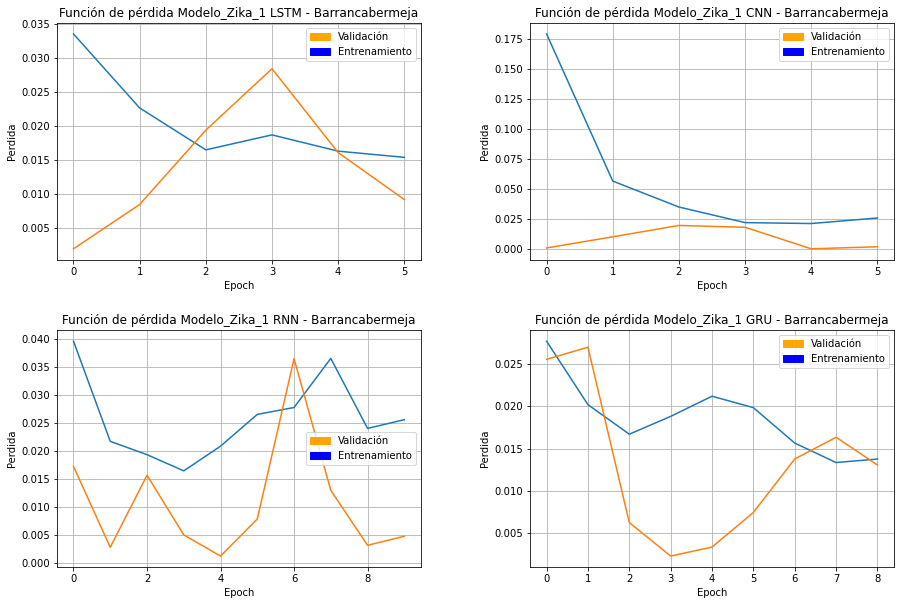

In [19]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Zika_1 LSTM - Barrancabermeja')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])

plt.subplot(2, 2, 2)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Zika_1 CNN - Barrancabermeja')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])

plt.subplot(2, 2, 3)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Zika_1 RNN - Barrancabermeja')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_RNN.history['loss'])
plt.plot(history_RNN.history['val_loss'])

plt.subplot(2, 2, 4)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Zika_1 GRU - Barrancabermeja')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])

plt.show()

# Gráficas de dispersión

1/1 [==============================] - 1s 1s/step


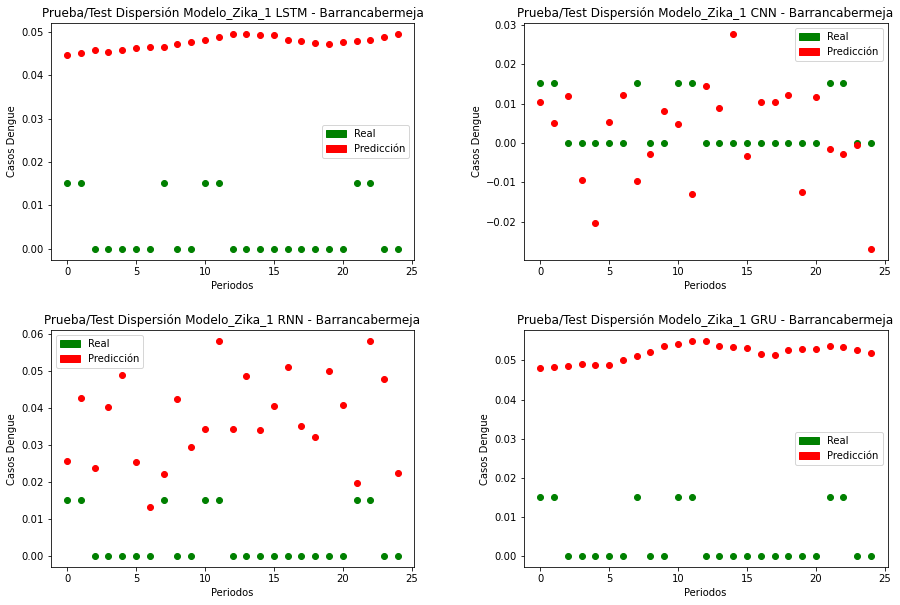

In [20]:
results_LSTM =Barr_LSTM_model_11.predict(X_test_LSTM)
results_CNN =Barr_CNN_model_11.predict(X_test_CNN)
results_RNN =Barr_RNN_model_11.predict(X_test_RNN)
results_GRU =Barr_GRU_model_11.predict(X_test_GRU)

plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Zika_1 LSTM - Barrancabermeja')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_LSTM)),y_test_LSTM,c='g')
plt.scatter(range(len(results_LSTM)),results_LSTM,c='r')

plt.subplot(2, 2, 2)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Zika_1 CNN - Barrancabermeja')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_CNN)),y_test_CNN,c='g')
plt.scatter(range(len(results_CNN)),results_CNN,c='r')

plt.subplot(2, 2, 3)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Zika_1 RNN - Barrancabermeja')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_RNN)),y_test_RNN,c='g')
plt.scatter(range(len(results_RNN)),results_RNN,c='r')

plt.subplot(2, 2, 4)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Zika_1 GRU - Barrancabermeja')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_GRU)),y_test_GRU,c='g')
plt.scatter(range(len(results_GRU)),results_GRU,c='r')

plt.show()

In [21]:
y_pred_LSTM = Barr_LSTM_model_11.predict(X_test_LSTM)
y_pred_CNN = Barr_CNN_model_11.predict(X_test_CNN)
y_pred_RNN = Barr_RNN_model_11.predict(X_test_RNN)
y_pred_GRU = Barr_GRU_model_11.predict(X_test_GRU)

y_train_inv_LSTM = dengue_transformer.inverse_transform(y_train_LSTM.reshape(1, -1))
y_train_inv_CNN = dengue_transformer.inverse_transform(y_train_CNN.reshape(1, -1))
y_train_inv_RNN = dengue_transformer.inverse_transform(y_train_RNN.reshape(1, -1))
y_train_inv_GRU = dengue_transformer.inverse_transform(y_train_GRU.reshape(1, -1))

y_test_inv_LSTM = dengue_transformer.inverse_transform(y_test_LSTM.reshape(1, -1))
y_test_inv_CNN = dengue_transformer.inverse_transform(y_test_CNN.reshape(1, -1))
y_test_inv_RNN = dengue_transformer.inverse_transform(y_test_RNN.reshape(1, -1))
y_test_inv_GRU = dengue_transformer.inverse_transform(y_test_GRU.reshape(1, -1))

y_pred_inv_LSTM = dengue_transformer.inverse_transform(y_pred_LSTM)
y_pred_inv_CNN = dengue_transformer.inverse_transform(y_pred_CNN)
y_pred_inv_RNN = dengue_transformer.inverse_transform(y_pred_RNN)
y_pred_inv_GRU = dengue_transformer.inverse_transform(y_pred_GRU)

1/1 [==============================] - 0s 31ms/step


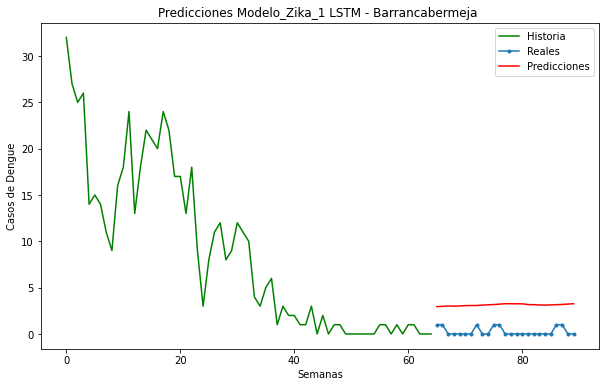

In [22]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_LSTM)), y_train_inv_LSTM.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_LSTM), len(y_train_LSTM) + len(y_test_LSTM)), y_test_inv_LSTM.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_LSTM), len(y_train_LSTM) + len(y_test_LSTM)), y_pred_inv_LSTM.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Zika_1 LSTM - Barrancabermeja ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

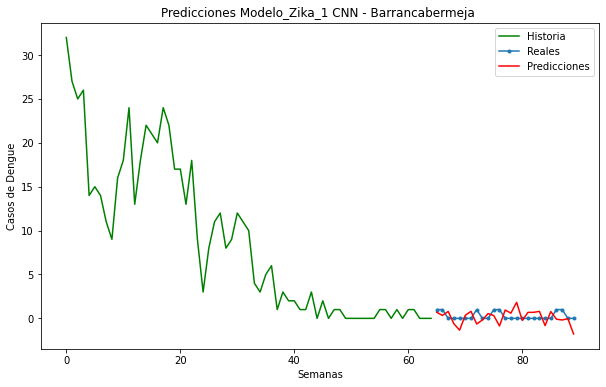

In [23]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_CNN)), y_train_inv_CNN.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_CNN), len(y_train_CNN) + len(y_test_CNN)), y_test_inv_CNN.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_CNN), len(y_train_CNN) + len(y_test_CNN)), y_pred_inv_CNN.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Zika_1 CNN - Barrancabermeja ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

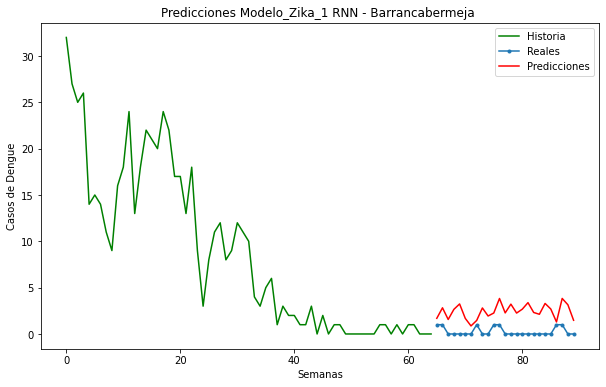

In [24]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_RNN)), y_train_inv_RNN.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_RNN), len(y_train_RNN) + len(y_test_RNN)), y_test_inv_RNN.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_RNN), len(y_train_RNN) + len(y_test_RNN)), y_pred_inv_RNN.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Zika_1 RNN - Barrancabermeja ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

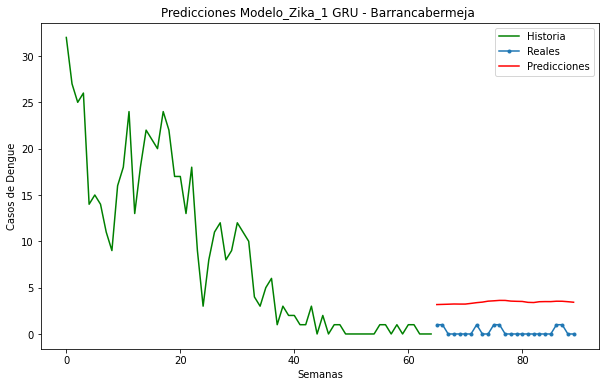

In [25]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_GRU)), y_train_inv_GRU.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_GRU), len(y_train_GRU) + len(y_test_GRU)), y_test_inv_GRU.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_GRU), len(y_train_GRU) + len(y_test_GRU)), y_pred_inv_GRU.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Zika_1 GRU - Barrancabermeja ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

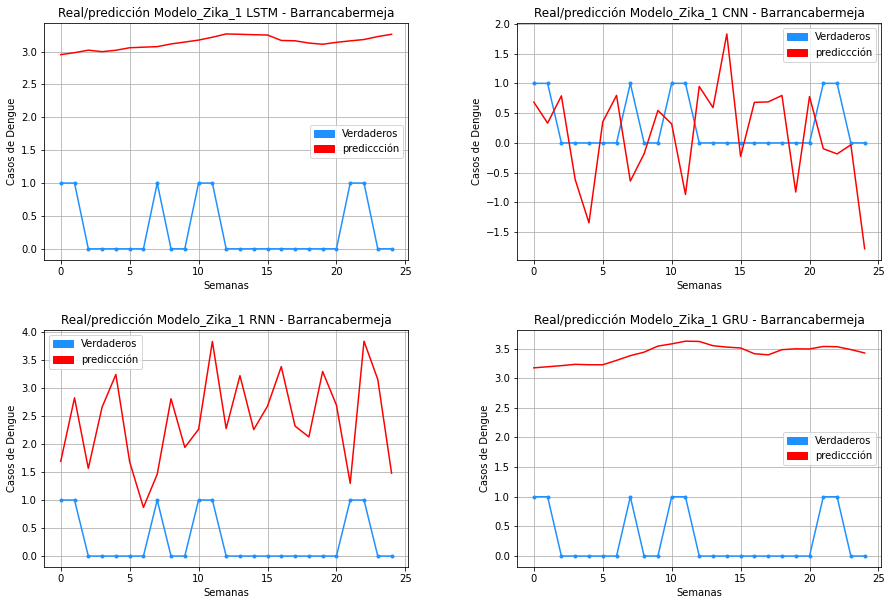

In [26]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
plt.title('Real/predicción Modelo_Zika_1 LSTM - Barrancabermeja' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_LSTM.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_LSTM.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.title('Real/predicción Modelo_Zika_1 CNN - Barrancabermeja' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_CNN.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_CNN.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.title('Real/predicción Modelo_Zika_1 RNN - Barrancabermeja' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_RNN.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_RNN.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.title('Real/predicción Modelo_Zika_1 GRU - Barrancabermeja' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_GRU.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_GRU.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.show()

In [27]:
score_LSTM = np.sqrt(metrics.mean_squared_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
score_CNN = np.sqrt(metrics.mean_squared_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
score_RNN = np.sqrt(metrics.mean_squared_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
score_GRU = np.sqrt(metrics.mean_squared_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

print("RMSE Modelo LSTM Zika Barranca : {}".format(score_LSTM))
print("RMSE Modelo CNN Zika Barranca  : {}".format(score_CNN))
print("RMSE Modelo RNN Zika Barranca  : {}".format(score_RNN))
print("RMSE Modelo GRU Zika Barranca  : {}".format(score_GRU))

RMSE Modelo LSTM Zika Barranca : 2.8966082072310977
RMSE Modelo CNN Zika Barranca  : 0.9870300392063501
RMSE Modelo RNN Zika Barranca  : 2.3354540349398336
RMSE Modelo GRU Zika Barranca  : 3.177558258276401


In [28]:
print("MSE Modelo LSTM Zika Barranca  = ", mean_squared_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("MSE Modelo CNN Zika Barranca   = ", mean_squared_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("MSE Modelo RNN Zika Barranca   = ", mean_squared_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("MSE Modelo GRU Zika Barranca   = ", mean_squared_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

MSE Modelo LSTM Zika Barranca  =  8.390339106198555
MSE Modelo CNN Zika Barranca   =  0.974228298295689
MSE Modelo RNN Zika Barranca   =  5.4543455493167485
MSE Modelo GRU Zika Barranca   =  10.096876484740555


In [29]:
print("MAE Modelo LSTM Zika Barranca = ", mean_absolute_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("MAE Modelo CNN Zika Barranca  = ", mean_absolute_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("MAE Modelo RNN Zika Barranca  = ", mean_absolute_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("MAE Modelo GRU Zika Barranca  = ", mean_absolute_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

MAE Modelo LSTM Zika Barranca =  2.857172899246216
MAE Modelo CNN Zika Barranca  =  0.8502347008883953
MAE Modelo RNN Zika Barranca  =  2.1534512138366697
MAE Modelo GRU Zika Barranca  =  3.143289813995361


In [30]:
print("r2_score Modelo LSTM Zika Barranca  = ", r2_score(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("r2_score Modelo CNN Zika Barranca  = ", r2_score(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("r2_score Modelo RNN Zika Barranca  = ", r2_score(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("r2_score Modelo GRU Zika Barranca  = ", r2_score(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

r2_score Modelo LSTM Zika Barranca  =  -40.61874556646108
r2_score Modelo CNN Zika Barranca  =  -3.8324816383714726
r2_score Modelo RNN Zika Barranca  =  -26.05528546288069
r2_score Modelo GRU Zika Barranca  =  -49.08371272192735


In [31]:
print("explained_variance_score Modelo LSTM Zika Barranca  = ", explained_variance_score(y_test_inv_LSTM.flatten(), 
                                                                                           y_pred_inv_LSTM.flatten()))
print("explained_variance_score Modelo CNN Zika Barranca  = ", explained_variance_score(y_test_inv_CNN.flatten(), 
                                                                                           y_pred_inv_CNN.flatten()))
print("explained_variance_score Modelo RNN Zika Barranca  = ", explained_variance_score(y_test_inv_RNN.flatten(), 
                                                                                           y_pred_inv_RNN.flatten()))
print("explained_variance_score Modelo GRU Zika Barranca  = ", explained_variance_score(y_test_inv_GRU.flatten(), 
                                                                                           y_test_inv_GRU.flatten()))

explained_variance_score Modelo LSTM Zika Barranca  =  -0.12550659727940872
explained_variance_score Modelo CNN Zika Barranca  =  -3.7265402705522996
explained_variance_score Modelo RNN Zika Barranca  =  -3.0525467209430612
explained_variance_score Modelo GRU Zika Barranca  =  1.0


### VISUALIZACIÓN DE LOS VALORES TESTEADOS VS LAS PREDICCIONES

In [32]:
#MODELO LSTM
resultados_LSTM = pd.DataFrame({ 'Actuales':y_test_inv_LSTM.flatten(), 'Predicciones': y_pred_inv_LSTM.flatten()})
resultados_LSTM['diferencia'] = resultados_LSTM['Predicciones'] - resultados_LSTM['Actuales']
print(resultados_LSTM.head(5))
print(resultados_LSTM.tail(5))

   Actuales  Predicciones  diferencia
0       1.0      2.953859    1.953859
1       1.0      2.983339    1.983339
2       0.0      3.021532    3.021532
3       0.0      2.998943    2.998943
4       0.0      3.020356    3.020356
    Actuales  Predicciones  diferencia
20       0.0      3.140448    3.140448
21       1.0      3.163443    2.163443
22       1.0      3.183429    2.183429
23       0.0      3.228525    3.228525
24       0.0      3.263578    3.263578


In [33]:
#MODELO CNN
resultados_CNN = pd.DataFrame({ 'Actuales':y_test_inv_CNN.flatten(), 'Predicciones': y_pred_inv_CNN.flatten()})
resultados_CNN['diferencia'] = resultados_CNN['Predicciones'] - resultados_CNN['Actuales']
print(resultados_CNN.head(5))
print(resultados_CNN.tail(5))

   Actuales  Predicciones  diferencia
0       1.0      0.684778   -0.315222
1       1.0      0.332576   -0.667424
2       0.0      0.790073    0.790073
3       0.0     -0.614586   -0.614586
4       0.0     -1.341675   -1.341675
    Actuales  Predicciones  diferencia
20       0.0      0.778928    0.778928
21       1.0     -0.097565   -1.097565
22       1.0     -0.184886   -1.184886
23       0.0     -0.032261   -0.032261
24       0.0     -1.778245   -1.778245


In [34]:
#MODELO RNN
resultados_RNN = pd.DataFrame({ 'Actuales':y_test_inv_RNN.flatten(), 'Predicciones': y_pred_inv_RNN.flatten()})
resultados_RNN['diferencia'] = resultados_RNN['Predicciones'] - resultados_RNN['Actuales']
print(resultados_RNN.head(5))
print(resultados_RNN.tail(5))

   Actuales  Predicciones  diferencia
0       1.0      1.690536    0.690536
1       1.0      2.824036    1.824036
2       0.0      1.564668    1.564668
3       0.0      2.658471    2.658471
4       0.0      3.240497    3.240497
    Actuales  Predicciones  diferencia
20       0.0      2.693788    2.693788
21       1.0      1.296947    0.296947
22       1.0      3.835090    2.835090
23       0.0      3.152021    3.152021
24       0.0      1.478932    1.478932


In [35]:
#MODELO GRU
resultados_GRU = pd.DataFrame({ 'Actuales':y_test_inv_GRU.flatten(), 'Predicciones': y_pred_inv_GRU.flatten()})
resultados_GRU['diferencia'] = resultados_GRU['Predicciones'] - resultados_GRU['Actuales']
print(resultados_GRU.head(5))
print(resultados_GRU.tail(5))

   Actuales  Predicciones  diferencia
0       1.0      3.174637    2.174637
1       1.0      3.192735    2.192735
2       0.0      3.211632    3.211632
3       0.0      3.233928    3.233928
4       0.0      3.226696    3.226696
    Actuales  Predicciones  diferencia
20       0.0      3.492898    3.492898
21       1.0      3.535218    2.535218
22       1.0      3.530715    2.530715
23       0.0      3.483038    3.483038
24       0.0      3.425303    3.425303
